### **Import Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Import Library**

In [2]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)
from sklearn.preprocessing import LabelEncoder
import cv2
import tensorflow as tf
import keras
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.metrics import accuracy_score, classification_report

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Load Data**

In [3]:
os.chdir('/content/drive/My Drive/Colab Notebooks/DATA RD/')
Train = glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATASETS/K-means Cluster/Train_K-means(5)/*')
Val=glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATASETS/K-means Cluster/Val_K-means(5)/*')
Test=glob.glob('/content/drive/My Drive/Colab Notebooks/DATA RD/DATASETS/K-means Cluster/Test_K-means(5)/*')

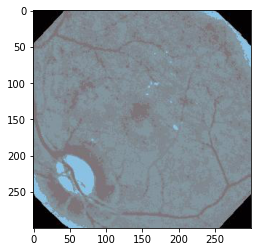

In [4]:
import matplotlib.image as mpimg
for ima in Train[600:601]:
     img=mpimg.imread(ima)
     imgplot = plt.imshow(img)
     plt.show()

### **Data Preparation**

In [5]:
nrows = 224
ncolumns = 224
channels = 3  

def read_and_process_image(list_of_images):
    
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'Normal' in image:
            y.append(0)
        elif 'Mild' in image:
            y.append(1)
        elif 'Moderate' in image:
            y.append(2)
        elif 'Severe' in image:
            y.append(3)

    
    return X, y

In [6]:
X_train, y_train = read_and_process_image(Train)
X_val, y_val = read_and_process_image(Val)
X_test, y_test = read_and_process_image(Test)

In [7]:
import seaborn as sns
import gc 
gc.collect()

#Convert list to numpy array
X_train = np.array(X_train)
y_train= np.array(y_train)

X_val = np.array(X_val)
y_val= np.array(y_val)

X_test = np.array(X_test)
y_test= np.array(y_test)

print('Train:',X_train.shape,y_train.shape)
print('Val:',X_val.shape,y_val.shape)
print('Test',X_test.shape,y_test.shape)

Train: (6000, 224, 224, 3) (6000,)
Val: (1500, 224, 224, 3) (1500,)
Test (500, 224, 224, 3) (500,)


Text(0.5, 1.0, 'Total Data Training')

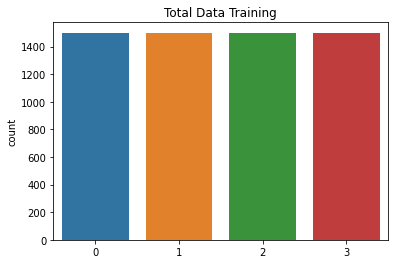

In [8]:
sns.countplot(y_train)
plt.title('Total Data Training')

Text(0.5, 1.0, 'Total Data Validasi')

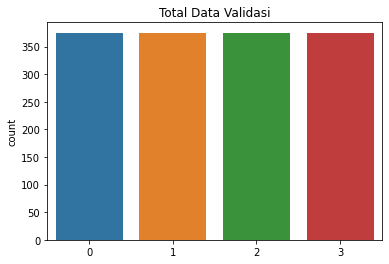

In [9]:
sns.countplot(y_val)
plt.title('Total Data Validasi')

Text(0.5, 1.0, 'Total Data Test')

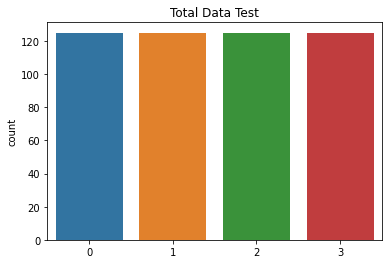

In [10]:
sns.countplot(y_test)
plt.title('Total Data Test')

In [11]:
y_train_ohe = pd.get_dummies(y_train)
y_val_ohe=pd.get_dummies(y_val)
y_test_ohe=pd.get_dummies(y_test)

y_train_ohe.shape,y_val_ohe.shape,y_test_ohe.shape

((6000, 4), (1500, 4), (500, 4))

### **Model Parameters**

In [12]:
batch_size = 16
EPOCHS = 100
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

### **Data Generator**

In [13]:
train_datagen =tf.keras.preprocessing.image.ImageDataGenerator(
                                  rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

test_datagen=tf.keras.preprocessing.image.ImageDataGenerator()

In [14]:
train_generator = train_datagen.flow(X_train, y_train_ohe, batch_size=batch_size)
val_generator = test_datagen.flow(X_val, y_val_ohe, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test_ohe, batch_size=batch_size)

### **EVALUASI DENSNET**

In [15]:
input_shape = (224,224,3)
model_input =tf.keras.Input(shape=input_shape)

Base_model1 =tf.keras.applications.DenseNet201(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)
for layer in Base_model1.layers:
    layer.trainable = True

In [16]:
Base_model1_last_layer = Base_model1.get_layer('relu')
print('last layer output shape:',Base_model1_last_layer.output_shape)
Base_model1_last_output = Base_model1_last_layer.output

last layer output shape: (None, 7, 7, 1920)


In [17]:
x1 =tf.keras.layers.GlobalAveragePooling2D()(Base_model1_last_output)
x1 =tf.keras.layers.Dropout(0.25)(x1)
x1 =tf.keras.layers.Dense(512, activation='relu')(x1)
x1 =tf.keras.layers.Dropout(0.25)(x1)
final_output1 =tf.keras.layers.Dense(4, activation='softmax', name='final_output')(x1)
DensNet201_model =tf.keras.models.Model(model_input, final_output1)
metric_list = ["accuracy"]
optimizer =tf.keras.optimizers.Adam(lr= 6.2500e-06)
DensNet201_model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
DensNet201_model.load_weights('/content/drive/My Drive/Colab Notebooks/DATA RD/MODEL/Weights/K=5/Weight_DensNet201_Optimal_(k=5).h5')

**EVALUASI DENSNET PADA DATA VALIDASI**

In [18]:
loss_val, acc_val = DensNet201_model.evaluate(X_val,y_val_ohe,batch_size=1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1500/1500 [==============================] - 43s 29ms/step - loss: 0.3587 - accuracy: 0.8860
Validation: accuracy = 0.886000  ;  loss_v = 0.358663


In [19]:
Validation_pred = DensNet201_model.predict(X_val)
Prdict_label = np.argmax(Validation_pred, -1)
Actual_label = y_val

print('Accuracy on Validation Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Validation Data: 88.60%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       375
           1       0.88      0.93      0.91       375
           2       0.79      0.82      0.80       375
           3       0.90      0.81      0.85       375

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



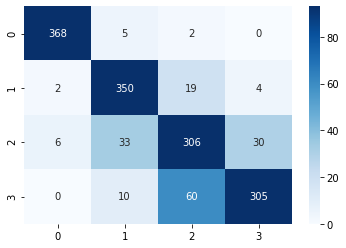

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(Actual_label , Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_val.shape[0]//16)

**EVALUASI DENSNET PADA DATA TEST**

In [21]:
loss_test, acc_test =DensNet201_model.evaluate(X_test,y_test_ohe,batch_size=1, verbose=1)
print("Test: accuracy = %f  ;  loss_v = %f" % (acc_test, loss_test))

500/500 [==============================] - 14s 28ms/step - loss: 0.4107 - accuracy: 0.8840
Test: accuracy = 0.884000  ;  loss_v = 0.410651


In [22]:
Test_predict = DensNet201_model.predict(X_test)

Prdict_label = np.argmax(Test_predict, -1)
Actual_label = y_test

print('Accuracy on Test Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Test Data: 88.40%
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       125
           1       0.84      0.90      0.87       125
           2       0.81      0.84      0.82       125
           3       0.94      0.82      0.88       125

    accuracy                           0.88       500
   macro avg       0.89      0.88      0.88       500
weighted avg       0.89      0.88      0.88       500



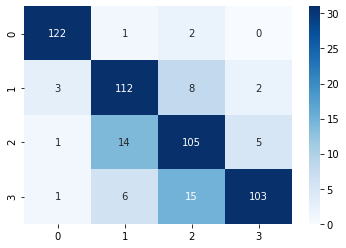

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(Actual_label, Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_test.shape[0]//16)

### **EVALUASI INCEPTIONV3**

In [24]:
Base_model2 =tf.keras.applications.InceptionV3(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)
for layer in Base_model2.layers:
    layer.trainable = True

In [25]:
Base_model2_last_layer = Base_model2.get_layer('mixed10')
print('last layer output shape:', Base_model2_last_layer.output_shape)
Base_model2_last_output = Base_model2_last_layer.output

last layer output shape: (None, 5, 5, 2048)


In [26]:
x2 =tf.keras.layers.GlobalAveragePooling2D()(Base_model2_last_output)
x2 =tf.keras.layers.Dropout(0.25)(x2)
x2 =tf.keras.layers.Dense(1024, activation='relu')(x2)
x2 =tf.keras.layers.Dropout(0.25)(x2)
final_output2 =tf.keras.layers.Dense(4, activation='softmax', name='final_output2')(x2)
InceptionV3_model =tf.keras.models.Model(model_input, final_output2)
metric_list = ["accuracy"]
optimizer = tf.keras.optimizers.Adam(2.5000e-05)
InceptionV3_model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
InceptionV3_model.load_weights('/content/drive/My Drive/Colab Notebooks/DATA RD/MODEL/Weights/K=5/Weight_InceptionV3_Optimal_(k=5).h5')

**EVALUASI INCEPTIONV3 PADA DATA VALIDASI**

In [27]:
loss_val, acc_val = InceptionV3_model.evaluate(X_val,y_val_ohe,batch_size=1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1500/1500 [==============================] - 22s 15ms/step - loss: 0.3884 - accuracy: 0.8360
Validation: accuracy = 0.836000  ;  loss_v = 0.388448


In [28]:
Validation_pred = InceptionV3_model.predict(X_val)
Prdict_label = np.argmax(Validation_pred, -1)
Actual_label = y_val

print('Accuracy on Validation Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Validation Data: 83.60%
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       375
           1       0.88      0.79      0.83       375
           2       0.70      0.81      0.75       375
           3       0.82      0.77      0.79       375

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500



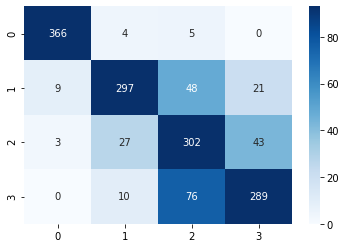

In [29]:
sns.heatmap(confusion_matrix(Actual_label , Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_val.shape[0]//16)

**EVALUASI INCEPTIONV3 PADA DATA TEST**

In [30]:
loss_test, acc_test = InceptionV3_model.evaluate(X_test,y_test_ohe,batch_size=1, verbose=1)
print("Test: accuracy = %f  ;  loss_v = %f" % (acc_test, loss_test))

500/500 [==============================] - 7s 15ms/step - loss: 0.3897 - accuracy: 0.8400
Test: accuracy = 0.840000  ;  loss_v = 0.389661


In [31]:
Test_predict = InceptionV3_model.predict(X_test)

Prdict_label = np.argmax(Test_predict, -1)
Actual_label = y_test

print('Accuracy on Test Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Test Data: 84.00%
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       125
           1       0.86      0.78      0.82       125
           2       0.72      0.82      0.77       125
           3       0.83      0.78      0.81       125

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



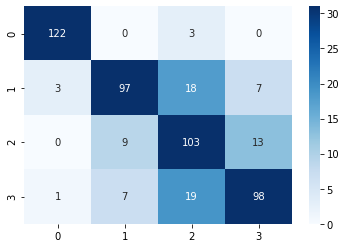

In [32]:
sns.heatmap(confusion_matrix(Actual_label, Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_test.shape[0]//16)

### **EVALUASI MOBILENETV3**

In [33]:
Base_model3 =tf.keras.applications.MobileNetV2(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)
for layer in Base_model3.layers:
    layer.trainable = True

In [34]:
Base_model3_last_layer = Base_model3.get_layer('out_relu')
print('last layer output shape:', Base_model3_last_layer.output_shape)
Base_model3_last_output = Base_model3_last_layer.output

last layer output shape: (None, 7, 7, 1280)


In [35]:
x3 =tf.keras.layers.GlobalAveragePooling2D()(Base_model3_last_output)
x3 =tf.keras.layers.Dropout(0.5)(x3)
x3 =tf.keras.layers.Dense(512, activation='relu')(x3)
x3 =tf.keras.layers.Dropout(0.5)(x3)
final_output3 =tf.keras.layers.Dense(4, activation='softmax', name='final_output3')(x3)
MobileNetV2_model =tf.keras.models.Model(model_input, final_output3)
metric_list = ["accuracy"]
optimizer = tf.keras.optimizers.Adam(lr=1.2500e-05)
MobileNetV2_model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
MobileNetV2_model.load_weights('/content/drive/My Drive/Colab Notebooks/DATA RD/MODEL/Weights/K=5/Weight_MobileNetV2_Optimal_(5).h5')

**EVALUASI MOBILENETV2 PADA DATA VALIDASI**

In [36]:
loss_val, acc_val = MobileNetV2_model.evaluate(X_val,y_val_ohe,batch_size=1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1500/1500 [==============================] - 9s 6ms/step - loss: 0.4272 - accuracy: 0.8307
Validation: accuracy = 0.830667  ;  loss_v = 0.427196


In [37]:
Validation_pred = MobileNetV2_model.predict(X_val)
Prdict_label = np.argmax(Validation_pred, -1)
Actual_label = y_val

print('Accuracy on Validation Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Validation Data: 83.07%
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       375
           1       0.80      0.87      0.83       375
           2       0.69      0.80      0.74       375
           3       0.90      0.70      0.79       375

    accuracy                           0.83      1500
   macro avg       0.84      0.83      0.83      1500
weighted avg       0.84      0.83      0.83      1500



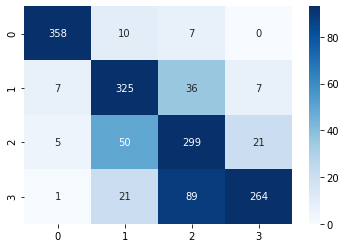

In [38]:
sns.heatmap(confusion_matrix(Actual_label , Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_val.shape[0]//16)

**EVALUASI MOBILENETV2 PADA DATA TEST**

In [39]:
loss_test, acc_test = MobileNetV2_model.evaluate(X_test,y_test_ohe,batch_size=1, verbose=1)
print("Test: accuracy = %f  ;  loss_v = %f" % (acc_test, loss_test))

500/500 [==============================] - 3s 6ms/step - loss: 0.4483 - accuracy: 0.8420
Test: accuracy = 0.842000  ;  loss_v = 0.448306


In [40]:
Test_predict = MobileNetV2_model.predict(X_test)

Prdict_label = np.argmax(Test_predict, -1)
Actual_label = y_test

print('Accuracy on Test Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Test Data: 84.20%
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       125
           1       0.82      0.83      0.83       125
           2       0.71      0.81      0.76       125
           3       0.89      0.74      0.81       125

    accuracy                           0.84       500
   macro avg       0.85      0.84      0.84       500
weighted avg       0.85      0.84      0.84       500



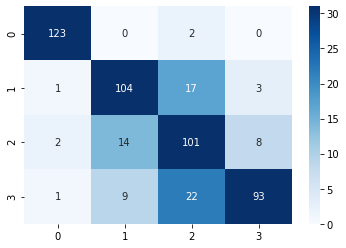

In [41]:
sns.heatmap(confusion_matrix(Actual_label, Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_test.shape[0]//16)

### **ENSAMBLE**

In [42]:
def ensemble(models, model_input):
    outputs = [model.outputs[0] for model in models]
    y =tf.keras.layers.Average()(outputs)
    model =tf.keras.Model(model_input,y,name='ensemble')
    return model

In [43]:
ensemble_model = ensemble([DensNet201_model,InceptionV3_model,MobileNetV2_model], model_input)
metric_list = ["accuracy"]
optimizer =tf.keras.optimizers.Adam(lr=2.5000e-05)
ensemble_model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)

**EVALUASI ENSAMBLE PADA DATA VALIDASI**

In [44]:
loss_val, acc_val = ensemble_model.evaluate(X_val,y_val_ohe,batch_size=1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1500/1500 [==============================] - 69s 46ms/step - loss: 0.2967 - accuracy: 0.8900
Validation: accuracy = 0.890000  ;  loss_v = 0.296744


In [45]:
Validation_pred = ensemble_model.predict(X_val)
Prdict_label = np.argmax(Validation_pred, -1)
Actual_label = y_val

print('Accuracy on Validation Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Validation Data: 89.00%
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       375
           1       0.88      0.93      0.91       375
           2       0.79      0.85      0.82       375
           3       0.91      0.80      0.85       375

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



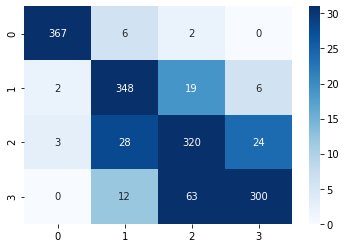

In [46]:
sns.heatmap(confusion_matrix(Actual_label, Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_test.shape[0]//16)

**EVALUASI ENSAMBLE PADA DATA TEST**

In [47]:
loss_test, acc_test = ensemble_model.evaluate(X_test,y_test_ohe,batch_size=1, verbose=1)
print("Test: accuracy = %f  ;  loss_v = %f" % (acc_test, loss_test))

500/500 [==============================] - 23s 46ms/step - loss: 0.3090 - accuracy: 0.8840
Test: accuracy = 0.884000  ;  loss_v = 0.308995


In [48]:
Test_predict = ensemble_model.predict(X_test)

Prdict_label = np.argmax(Test_predict, -1)
Actual_label = y_test

print('Accuracy on Test Data: %2.2f%%' % (100*accuracy_score(Actual_label, Prdict_label)))
print(classification_report(Actual_label, Prdict_label))

Accuracy on Test Data: 88.40%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       125
           1       0.85      0.88      0.87       125
           2       0.79      0.86      0.83       125
           3       0.92      0.81      0.86       125

    accuracy                           0.88       500
   macro avg       0.89      0.88      0.88       500
weighted avg       0.89      0.88      0.88       500



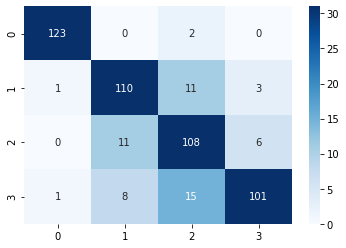

In [49]:
sns.heatmap(confusion_matrix(Actual_label, Prdict_label), 
            annot=True, fmt="d", cbar = True, cmap = plt.cm.Blues, vmax = X_test.shape[0]//16)

In [50]:
ensemble_model.save('Ensamble_Model(k=5).h5')
ensemble_model.save_weights('Weight_Ensamble_Model(k=5).h5')